
# **Micro Analysis**

Importing Libraries and Loading the Dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

# Models & metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score
)

**Loading dataset**

In [7]:
df=pd.read_csv("C:\\Users\\shrey\\Downloads\\micro_gait_data (2).csv")
df.head()

,subject,condition,replication,leg,joint,time,angle,vel,acc
0,1,1,1,1,1,0,4.682881,0.390246,-0.233599
1,1,1,1,1,1,1,5.073127,0.390246,-0.233599
2,1,1,1,1,1,2,5.229774,0.156647,-0.233599
3,1,1,1,1,1,3,5.083273,-0.146502,-0.303149
4,1,1,1,1,1,4,4.652399,-0.430874,-0.284372


In [8]:
# Checking basic structure
print(f"Data shape: {df.shape}")
print(f"Subjects: {df['subject'].nunique()}")
print(f"Conditions: {df['condition'].unique()} -> {['normal', 'knee_brace', 'ankle_brace']}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Verifying time series structure
time_points_per_cycle = df.groupby(['subject','condition','replication','leg','joint'])['time'].count()
print(f"Time points per cycle: {time_points_per_cycle.unique()}")

Data shape: (181800, 9)
Subjects: 10
Conditions: [1 2 3] -> ['normal', 'knee_brace', 'ankle_brace']
Missing values: 0
Time points per cycle: [101]


# Feature Engineering

**Engineering jerk**

In [9]:
df['jerk'] = df.groupby(['subject','condition','replication','leg','joint'])['acc'].diff() / df.groupby(['subject','condition','replication','leg','joint'])['time'].diff()
df['jerk'] = df['jerk'].interpolate(method='linear', limit_direction='both')

**Calculating Symmetry index, Stability score & Gait score**

In [10]:
eps = 1e-6

left  = df[df['leg'] == 1].copy()
right = df[df['leg'] == 2].copy()

# Merge left and right (joining using merge)
paired = pd.merge(
    left,
    right,
    on=['subject','condition','replication','joint','time'],
    suffixes=('_L','_R'),
    how='inner'
)

# Symmetry Index (pairwise)
paired['symmetry_pair'] = 1 - (
    np.abs(paired['angle_L'] - paired['angle_R']) /
    (np.abs(paired['angle_L']) + np.abs(paired['angle_R']) + eps)
)

paired['symmetry_pair'] = paired['symmetry_pair'].clip(0,1)

# Per-leg stability separately
stab = (
    df.groupby(['subject','condition','replication','leg','joint'])
      .agg(std_angle=('angle','std'),
            range_angle=('angle', lambda x: x.max() - x.min()))
      .reset_index()
)

stab['stability_score'] = 1 - (
    stab['std_angle'] / (stab['range_angle'] + eps)
)
stab['stability_score'] = stab['stability_score'].clip(0,1)

# Split stability back into left and right
stab_L = stab[stab['leg']==1].copy().rename(columns={'stability_score':'stability_L'})
stab_R = stab[stab['leg']==2].copy().rename(columns={'stability_score':'stability_R'})

# Attach stability values to paired table
paired = paired.merge(
    stab_L[['subject','condition','replication','joint','stability_L']],
    on=['subject','condition','replication','joint'],
    how='left')

paired = paired.merge(
    stab_R[['subject','condition','replication','joint','stability_R']],
    on=['subject','condition','replication','joint'],
    how='left')

paired['symmetry_L'] = paired['symmetry_pair']
paired['symmetry_R'] = paired['symmetry_pair']

# Gait score per leg 
paired['gait_L'] = 50*paired['symmetry_L'] + 50*paired['stability_L']
paired['gait_R'] = 50*paired['symmetry_R'] + 50*paired['stability_R']

left_rows = paired[['subject','condition','replication','joint','time',
                    'angle_L','symmetry_L','stability_L','gait_L']].copy()
left_rows['leg'] = 1
left_rows = left_rows.rename(columns={
    'angle_L':'angle',
    'symmetry_L':'symmetry_index',
    'stability_L':'stability_score',
    'gait_L':'gait_score'})

right_rows = paired[['subject','condition','replication','joint','time',
                     'angle_R','symmetry_R','stability_R','gait_R']].copy()
right_rows['leg'] = 2
right_rows = right_rows.rename(columns={
    'angle_R':'angle',
    'symmetry_R':'symmetry_index',
    'stability_R':'stability_score',
    'gait_R':'gait_score'})

# Stack them together
per_leg_scores = pd.concat([left_rows, right_rows], ignore_index=True)

df = df.drop(columns=['symmetry_index_x','symmetry_index_y',
                      'stability_score_x','stability_score_y',
                      'gait_score_x','gait_score_y'], errors='ignore')

df = df.merge(
    per_leg_scores,
    on=['subject','condition','replication','leg','joint','time'],
    how='left')

#removing extra angle columns
df['angle'] = df['angle_y']
df = df.drop(columns=['angle_x','angle_y'])

print(df[['subject','condition','replication','leg','joint','time',
          'symmetry_index','stability_score','gait_score']].head(5))

   subject  condition  replication  leg  joint  time  symmetry_index  \
0        1          1            1    1      1     0        0.965671   
1        1          1            1    1      1     1        0.978959   
2        1          1            1    1      1     2        0.983012   
3        1          1            1    1      1     3        0.981905   
4        1          1            1    1      1     4        0.982914   

   stability_score  gait_score  
0         0.752097   85.888401  
1         0.752097   86.552819  
2         0.752097   86.755473  
3         0.752097   86.700098  
4         0.752097   86.750562  


In [11]:
df.shape

(181800, 13)

# Exploratory Data Analysis (EDA)

In [12]:
import matplotlib.pyplot as plt

def plot_subject(subj, cond, rep=1, leg=1):
    subset = df[
        (df['subject'] == subj) &
        (df['condition'] == cond) &
        (df['replication'] == rep) &
        (df['leg'] == leg)]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    cols = ['angle', 'vel', 'acc', 'jerk']

    for i, col in enumerate(cols):
        for j in sorted(subset['joint'].unique()):
            temp = subset[subset['joint'] == j]
            axes[i].plot(temp['time'], temp[col], label=f'Joint {j}', linewidth=1.5)

        axes[i].set_title(f"{col.capitalize()} vs Time (All 3 Joints)")
        axes[i].set_xlabel("Time (frames)")
        axes[i].set_ylabel(col)
        axes[i].grid(True)
        axes[i].legend()

    plt.suptitle(f"Subject {subj} | Condition {cond} | Replication {rep} | Leg {leg}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

The function is for the visualization of a subject's condition (normal, knee braced, ankle braced), at replication 1 and leg 1 as shown below 

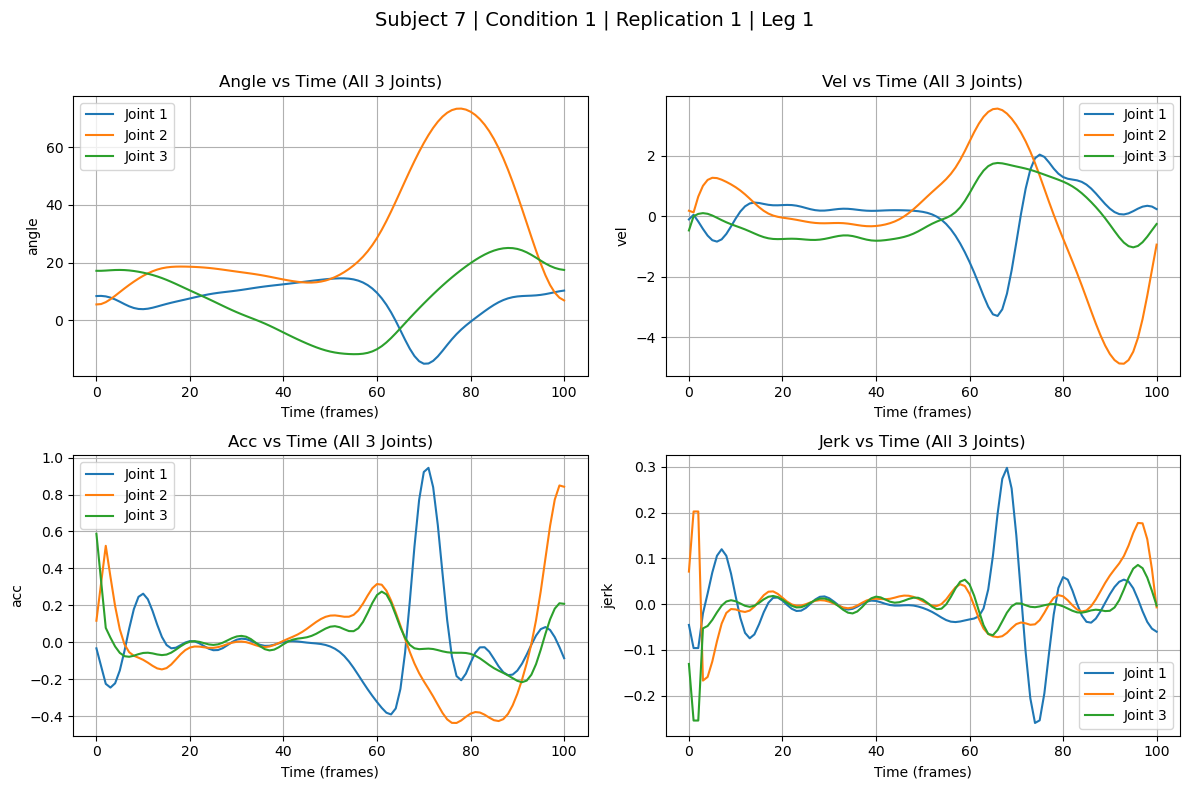

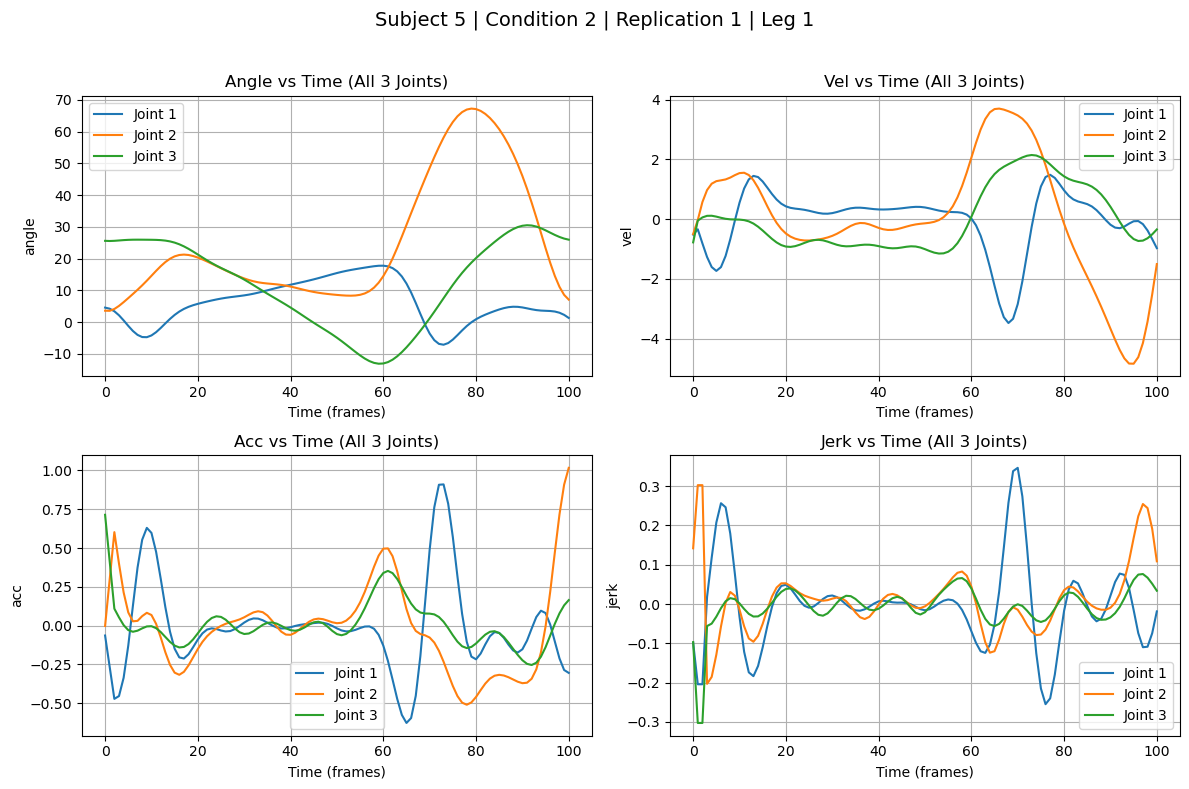

In [13]:
plot_subject(7,1)
plot_subject(5,2)

To visualize the overall replications of all the sujbects along with thier mean for all 3 conditions: 

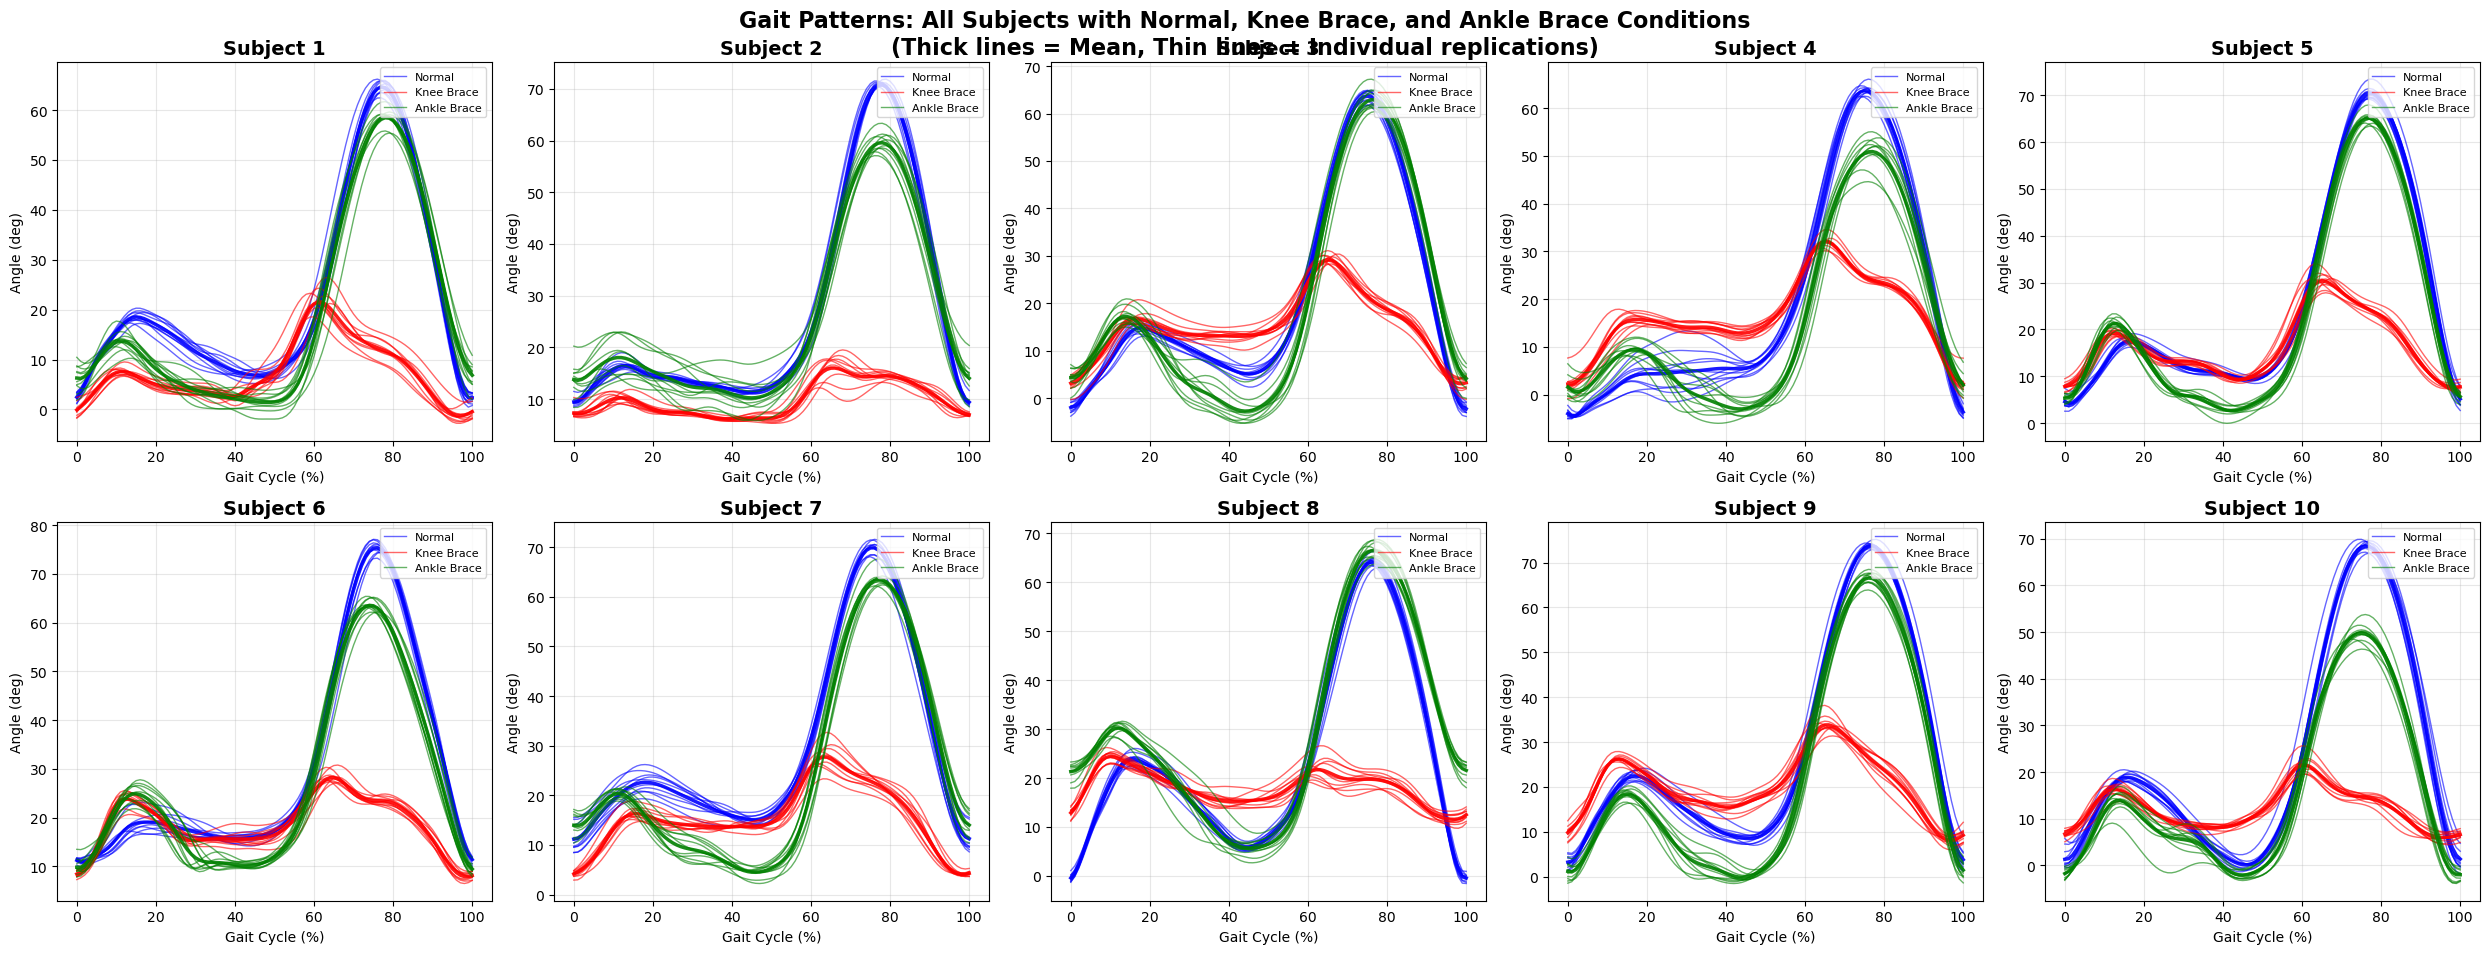

In [14]:
def plot_all_subjects_conditions(data, leg=2, joint=2):

    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    axes = axes.flatten()

    conditions = ['Normal', 'Knee Brace', 'Ankle Brace']
    colors = ['blue', 'red', 'green']

    for subject in range(1, 11):
        ax = axes[subject-1]

        for cond_idx, condition in enumerate([1, 2, 3]):
            cycles_data = data[(data['subject'] == subject) &
                              (data['condition'] == condition) &
                              (data['leg'] == leg) &
                              (data['joint'] == joint)]

            for rep in range(1, 11):
                rep_data = cycles_data[cycles_data['replication'] == rep].sort_values('time')
                ax.plot(rep_data['time'], rep_data['angle'],
                       color=colors[cond_idx],
                       alpha=0.6,
                       linewidth=1,
                       label=conditions[cond_idx] if rep == 1 else "")


            mean_angle = cycles_data.groupby('time')['angle'].mean()
            ax.plot(mean_angle.index, mean_angle.values,
                   color=colors[cond_idx], linewidth=2.5, alpha=0.9)

        ax.set_title(f'Subject {subject}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Gait Cycle (%)')
        ax.set_ylabel('Angle (deg)')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=8)

    plt.suptitle('Gait Patterns: All Subjects with Normal, Knee Brace, and Ankle Brace Conditions\n(Thick lines = Mean, Thin lines = Individual replications)',
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()


plot_all_subjects_conditions(df)

For almost all subjects we can observe that the angle produced in the normal condition is more than that of knee and ankle braced conditions. And we see a sudden rise in the graph approximately around the time point 50. It can also be ovserved across all the subjects that the range of angle is different it can be suspected due to lenght(height) differences of the subjects. 

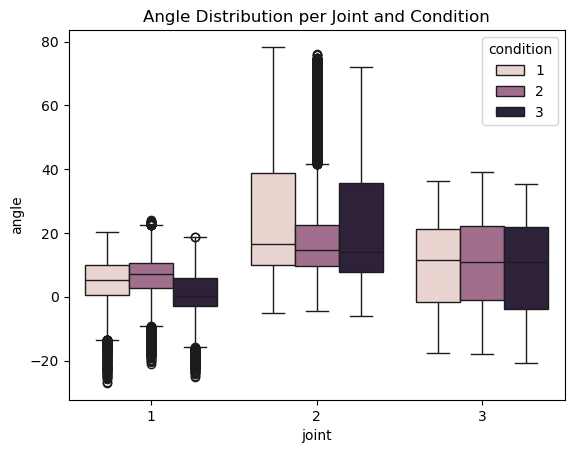

In [15]:
sns.boxplot(data=df, x='joint', y='angle', hue='condition')
plt.title('Angle Distribution per Joint and Condition')
plt.show()

The above boxplot indicates the presence of outliers with respect to angle and joint. we can observe that the hip joint has outliers in the case of all 3 conditions and has the smallest range of angles, knee joint has a larger range of angle as observed in the plots priorly and has the presence of outliers in the knee braced condition, ankle joint has no outliers. 

# Preprocessing

Scaling the numerical features and encoding the categorical features

In [16]:
num_cols = ['angle', 'vel', 'acc', 'jerk', 'symmetry_index', 'stability_score', 'gait_score']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# One-hot encoding on the leg & joint attributes
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[['leg', 'joint']])
encoded_cols = encoder.get_feature_names_out(['leg', 'joint'])
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
df = pd.concat([df, df_encoded], axis=1)

print("Added scaled copies and encoded leg/joint columns. Data shape now:", df.shape)

Added scaled copies and encoded leg/joint columns. Data shape now: (181800, 16)


In [17]:
df.columns

Index(['subject', 'condition', 'replication', 'leg', 'joint', 'time', 'vel',
       'acc', 'jerk', 'symmetry_index', 'stability_score', 'gait_score',
       'angle', 'leg_2', 'joint_2', 'joint_3'],
      dtype='object')

# Anomaly Detection

In [18]:
features = ['angle','vel','acc','jerk',
            'symmetry_index','stability_score','gait_score']

X = df[features]
y = df['condition']

In [19]:
X_healthy = X[y == 1]
X_test = X[(y == 2) | (y==3)]

In [20]:
print("All features:", X.shape)
print("Healthy subset:", X_healthy.shape)
print("Anomalous subset:", X_test.shape)
print("Sample features:\n", X.head())

All features: (181800, 7)
Healthy subset: (60600, 7)
Anomalous subset: (121200, 7)
Sample features:
       angle       vel       acc      jerk  symmetry_index  stability_score  \
0 -0.465902  0.301872 -1.101286 -0.001198        0.851611         1.519171   
1 -0.441551  0.301872 -1.101286 -0.001198        0.890094         1.519171   
2 -0.431776  0.121458 -1.101286 -0.001198        0.901832         1.519171   
3 -0.440918 -0.112671 -1.427881 -0.978285        0.898624         1.519171   
4 -0.467804 -0.332299 -1.339710  0.262586        0.901547         1.519171   

   gait_score  
0    1.035898  
1    1.075401  
2    1.087449  
3    1.084157  
4    1.087157  


In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_healthy)    # fit only on healthy data
X_test_scaled = scaler.transform(X_test)      # transform braced data
X_all_scaled = scaler.transform(X)

**USING ISOLATION FOREST**

In [23]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # roughly % of anomalies expected
    random_state=42
)
iso.fit(X_scaled)

IsolationForest(contamination=0.05, n_estimators=200, random_state=42)

In [24]:
# Scores for both healthy and test data
healthy_scores = iso.decision_function(X_scaled)
test_scores = iso.decision_function(X_test_scaled)

# Predictions (-1 = anomaly, 1 = normal)
healthy_preds = iso.predict(X_scaled)
test_preds = iso.predict(X_test_scaled)

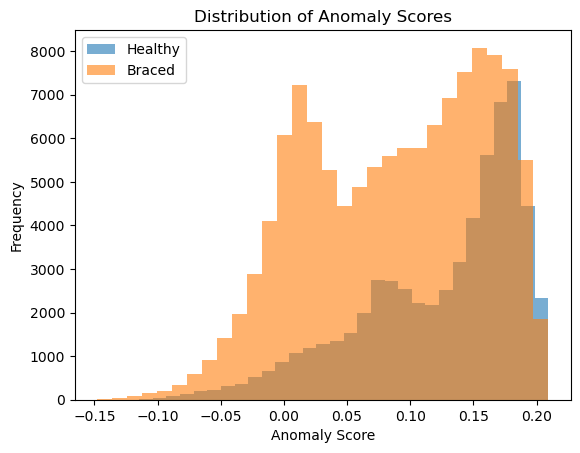

In [25]:
import matplotlib.pyplot as plt

plt.hist(healthy_scores, bins=30, alpha=0.6, label='Healthy')
plt.hist(test_scores, bins=30, alpha=0.6, label='Braced')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.show()

In [26]:
df_scores = df.copy()
df_scores['anomaly_if'] = iso.predict(X_all_scaled)
df_scores["is_anomaly_if"] = (df_scores["anomaly_if"] == -1).astype(int)

In [27]:
anomaly_by_time_if = df_scores.groupby("time")["is_anomaly_if"].mean()

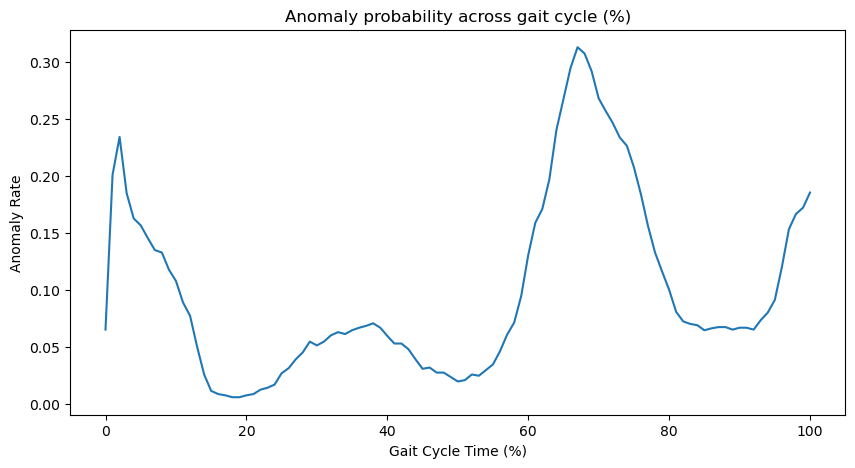

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
anomaly_by_time_if.plot()
plt.title("Anomaly probability across gait cycle (%)")
plt.xlabel("Gait Cycle Time (%)")
plt.ylabel("Anomaly Rate")
plt.show()

Isolation forest mostly detects the anomalies approximately at the 0th, 30th, 60th and 100th time point.

**USING ONE CLASS SVM**

In [29]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_scaled)

OneClassSVM(gamma='auto', nu=0.05)

In [30]:
X_all_scaled = scaler.transform(df[features])
df_scores["anomaly_svm"] = ocsvm.predict(X_all_scaled)  # +1 = normal, -1 = anomaly

In [31]:
df_scores["is_anomaly_svm"] = (df_scores["anomaly_svm"] == -1).astype(int)

In [32]:
anomaly_by_time_svm = df_scores.groupby("time")["is_anomaly_svm"].mean()

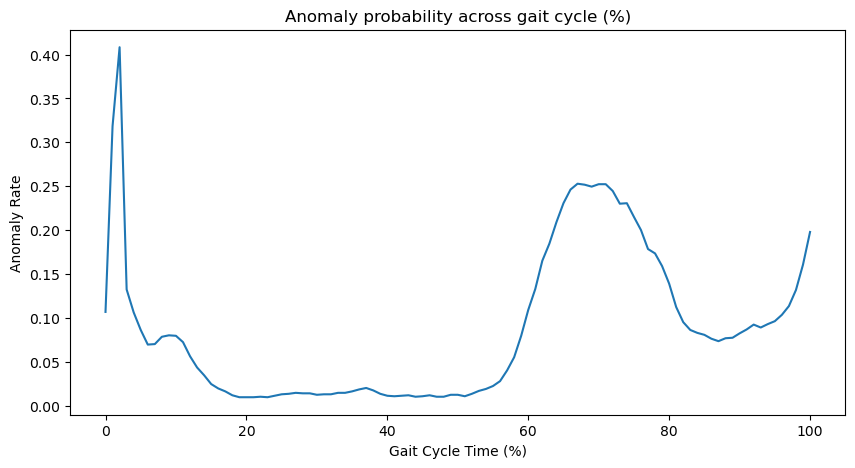

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
anomaly_by_time_svm.plot()
plt.title("Anomaly probability across gait cycle (%)")
plt.xlabel("Gait Cycle Time (%)")
plt.ylabel("Anomaly Rate")
plt.show()

One Class SVM mostly detects the anomalies approximately at 0th, 60th and 100th time point.

High anomaly regions are the exact gait frames where brace effect disrupts movement.

# Classification (Predicitng Gait Condition)

In [34]:
df['is_braced'] = df['condition'].apply(lambda x: 0 if x==1 else 1)
X = df[features]
y = df['is_braced']
groups = df['subject'] 

In [35]:
models = {
    "LogReg": LogisticRegression(max_iter=300, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=200),
    "GradientBoosting": GradientBoostingClassifier()}

In [36]:
gkf = GroupKFold(n_splits=8)
#Each fold splits by subject, not frames

In [37]:
results = {m: {"acc": [], "f1": [], "auc": []} for m in models}

for model_name, model in models.items():

    print(f"\nRunning model: {model_name}")
    
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Pipeline for clean scaling
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
        
        results[model_name]["acc"].append(acc)
        results[model_name]["f1"].append(f1)
        results[model_name]["auc"].append(auc)
        
        print(f" Fold {fold+1} | ACC: {acc:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")


Running model: LogReg
 Fold 1 | ACC: 0.622, F1: 0.663, AUC: 0.716
 Fold 2 | ACC: 0.648, F1: 0.669, AUC: 0.782
 Fold 3 | ACC: 0.560, F1: 0.578, AUC: 0.612
 Fold 4 | ACC: 0.589, F1: 0.602, AUC: 0.676
 Fold 5 | ACC: 0.566, F1: 0.571, AUC: 0.681
 Fold 6 | ACC: 0.634, F1: 0.646, AUC: 0.781
 Fold 7 | ACC: 0.585, F1: 0.626, AUC: 0.653
 Fold 8 | ACC: 0.624, F1: 0.637, AUC: 0.755

Running model: RandomForest
 Fold 1 | ACC: 0.727, F1: 0.809, AUC: 0.794
 Fold 2 | ACC: 0.754, F1: 0.827, AUC: 0.830
 Fold 3 | ACC: 0.658, F1: 0.766, AUC: 0.650
 Fold 4 | ACC: 0.733, F1: 0.799, AUC: 0.784
 Fold 5 | ACC: 0.712, F1: 0.785, AUC: 0.770
 Fold 6 | ACC: 0.778, F1: 0.841, AUC: 0.863
 Fold 7 | ACC: 0.684, F1: 0.790, AUC: 0.708
 Fold 8 | ACC: 0.756, F1: 0.823, AUC: 0.822

Running model: GradientBoosting
 Fold 1 | ACC: 0.695, F1: 0.791, AUC: 0.755
 Fold 2 | ACC: 0.742, F1: 0.818, AUC: 0.821
 Fold 3 | ACC: 0.646, F1: 0.764, AUC: 0.622
 Fold 4 | ACC: 0.699, F1: 0.778, AUC: 0.744
 Fold 5 | ACC: 0.701, F1: 0.788, AU

In [40]:
summary = []

for model in models:
    summary.append({
        "model": model,
        "acc_mean": np.mean(results[model]["acc"]),
        "f1_mean": np.mean(results[model]["f1"]),
        "auc_mean": np.nanmean(results[model]["auc"])
    })

summary_df = pd.DataFrame(summary).sort_values("f1_mean", ascending=False)
print("\nFINAL MODEL RANKING")
print(summary_df)


FINAL MODEL RANKING
              model  acc_mean   f1_mean  auc_mean
1      RandomForest  0.725175  0.805025  0.777647
2  GradientBoosting  0.708945  0.795877  0.758968
0            LogReg  0.603493  0.624158  0.706941


Random forest model shows the most accuracy which is around 72% (i.e the accuracy mean) which can be said as not good enough for clinical-data use, it can be considered as not safe for patient oriented decision making. Hence, from the results obtained from the micro analysis, we can conclude that the gait anomalies cannot be labelled (classification into braced and unbraced) very effectively using the micro model features of the subjects.